<h2 align="center">BERT Real-Time: Classify spam vs no spam emails</h2>

In [ ]:

!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 574.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.re

In [ ]:
!git clone https://github.com/Jaish19/NLP-IITD.git

Cloning into 'NLP-IITD'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 336.51 KiB | 6.60 MiB/s, done.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [ ]:
import pandas as pd

df = pd.read_csv("/content/NLP-IITD/Transformer & BERT/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df['Category'].value_counts()

,count
Category,
ham,4825
spam,747


In [ ]:
747/4825

0.15481865284974095

**15% spam emails, 85% ham emails: This indicates class imbalance**

In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['Category'].value_counts()

,count
Category,
ham,747
spam,747


In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1102,ham,"Yeah go on then, bored and depressed sittin wa...",0
1262,ham,Thank you so much. When we skyped wit kz and s...,0
813,spam,Congratulations ur awarded either £500 of CD g...,1
19,spam,England v Macedonia - dont miss the goals/team...,1
5380,ham,Its sunny in california. The weather's just cool,0


<h4>Split it into training and test data set</h4>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
X_train.head(4)

,Message
866,Congratulations ur awarded either a yrs supply...
4915,You've already got a flaky parent. It'snot sup...
4127,"SPJanuary Male Sale! Hot Gay chat now cheaper,..."
523,Were gonna go get some tacos


<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132724 , -0.8884571 , ..., -0.7474884 ,
        -0.7531473 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.7174535 ,  0.88082975]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [ ]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703827]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow.

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
len(X_train)

1120

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [ ]:
model.fit(X_train, y_train, epochs=1)

35/35 [==============================] - 518s 15s/step - loss: 0.6844 - accuracy: 0.5750 - precision: 0.5764 - recall: 0.5661


In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 166s 14s/step - loss: 0.5715 - accuracy: 0.8235 - precision: 0.9116 - recall: 0.7166


[0.5714947581291199,
 0.8235294222831726,
 0.9115646481513977,
 0.7165775299072266]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 169s 14s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[174,  13],
       [ 53, 134]])

Text(50.722222222222214, 0.5, 'Truth')

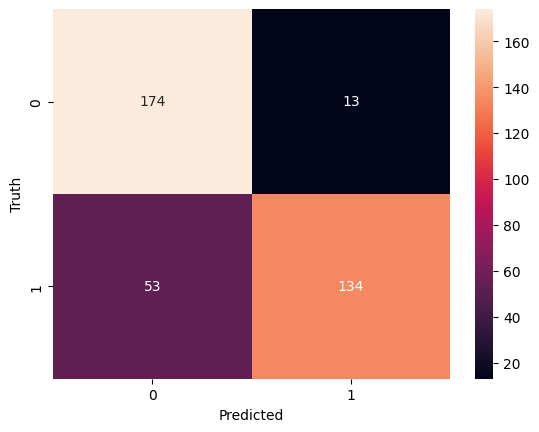

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       187
           1       0.91      0.72      0.80       187

    accuracy                           0.82       374
   macro avg       0.84      0.82      0.82       374
weighted avg       0.84      0.82      0.82       374



<h4>Inference</h4>

In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.5130701 ],
       [0.5426138 ],
       [0.53955793],
       [0.46645713],
       [0.4249835 ]], dtype=float32)